#  Intro

The goal of this task is to load and visualize the CIFAR-10 dataset, come up with a sensible benchmark, train and properly evaluate the model and select the optimal hyper-parameters. Unfortunately I do not have access to GPU, so SVM classification and parameters tuning will be run on a part of training dataset.

Data has been downloaded from: https://www.cs.toronto.edu/~kriz/cifar.html. Description of dataset:

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

# Data preparation

To keep the project clean, most of the helper functions are stored in python files - data_preparation.py and tsne_visualization.py which you can find in this github project.

In [1]:
from data_preparation import load_data, create_path_list, extract_features, visualize_images

Using TensorFlow backend.


First step is loading the data from pickle files that I downloaded from mentioned site. 

In [2]:
x_test, y_test = load_data('cifar-10-batches-py/test_batch')
x_train, y_train = load_data('cifar-10-batches-py/train_batch')

What we could also do is to use a shortcut version of downloading cifar-10 dataset by simply downloading it from keras.datasets.

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, x_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


The function below is creating all of the data images which are represented as vectors in .jpg format in folder /images. It will be useful later for feature extraction. What the function returns is the list of the paths to all of those images.

In [5]:
full_path_train = create_path_list(x_train, 'images/train/')
full_path_test = create_path_list(x_test, 'images/test/')

Next I'm plotting 10 random images from each class in the dataset. In every row you can see different class objects in a below order.

In [5]:
class_mapping = {0:'airplane',1:'automobile', 2:'bird', 3:'cat', 4:'deer', 
                 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

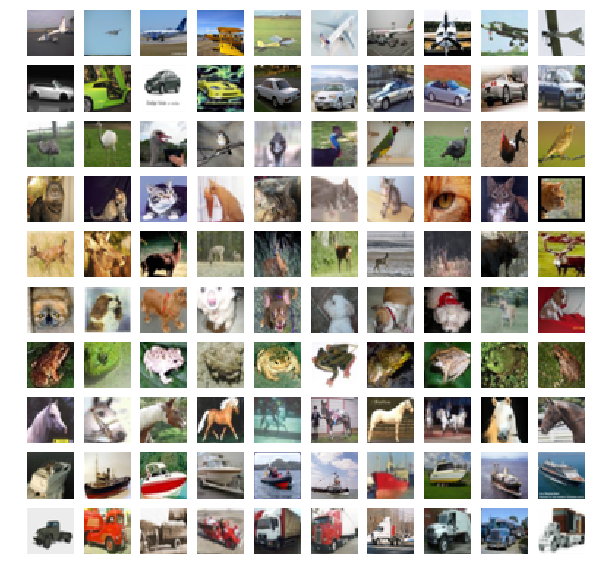

In [4]:
visualize_images(x_train,y_train, n_class = 10)

# Shallow classifier with GIST features

In [30]:
import gist
import pickle
from sklearn.metrics import classification_report
from sklearn.svm import SVC

def predict_svm(x_tr=x_train, x_te=x_test, y_tr=y_train, y_te=y_test, C=1, kernel='linear'):
    y_tr = [el[0] for el in y_tr]
    y_te = [el[0] for el in y_te]
    svm = SVC(C=C, kernel=kernel)
    svm.fit(x_tr, y_tr)
    print('Accuracy: {}'.format(svm.score(x_te, y_te)))

First try in classifying the images is creating a rather shallow classifier. There is a great Python library to extract GIST descriptor -> https://github.com/tuttieee/lear-gist-python which I would use to create GIST features. That will be an input to SVM classifier as it was described in the task. There is no point in experimenting with other descriptors such as SIFT or HOG, because better results could be achieved using pretrained networks to extract features.

In [5]:
gist_train = [gist.extract(arr) for arr in x_train]
gist_test = [gist.extract(arr) for arr in x_test]

SVM classification:

In [43]:
y_pred = predict_svm(gist_train, gist_test, y_train, y_test)
y_pred = [class_mapping[elem] for elem in y_pred]
y_t = [class_mapping[elem] for elem in y_test]
print('Classification report:')
print(classification_report(y_t, y_pred))

Accuracy: 0.6291
Classification report:
             precision    recall  f1-score   support

   airplane       0.62      0.71      0.66      1000
 automobile       0.74      0.75      0.74      1000
       bird       0.50      0.50      0.50      1000
        cat       0.44      0.42      0.43      1000
       deer       0.59      0.59      0.59      1000
        dog       0.51      0.50      0.50      1000
       frog       0.72      0.73      0.73      1000
      horse       0.71      0.66      0.69      1000
       ship       0.73      0.73      0.73      1000
      truck       0.74      0.70      0.72      1000

avg / total       0.63      0.63      0.63     10000



We've got a 63% accuracy result, which now would be treated as a baseline to beat. Here I used a few evaluation metrics - accuracy and metrics that are the part of classification report. Because distribution of classes is not skewed and they are equally divided, the prec/recall/f1_score metrics or roc_auc_score as well are not so useful and we can rely only on accuracy as a metric. In later experiments I will use only accuracy to measure the performance.

Let's try something more sofisticated and widely used in today's research and try to use pretrained neural network to extract features from the images using its weights.

# Inception - feature extraction

In this section I am trying to go deeper and create the features using pretrained Google's Inception_v3 model learned on ImageNet dataset. As suggested I am going to use pre-last layer's weights so the ones just before the softmax activation function.

I am using separate feature extractor for train and test set. I'm also saving those arrays, because this is a very time consuming process for my CPU.

In [21]:
features_train = extract_features(full_path_train, 'tensorflow_inception_graph.pb')
features_train = features_train.astype(np.float32)
#pickle.dump(features_train, open('features_train', 'wb'))

In [23]:
features_test = extract_features(full_path_test, 'tensorflow_inception_graph.pb')
features_test = features_test.astype(np.float32)
#pickle.dump(features_test, open('features_test', 'wb'))

# T-SNE visualization

In [11]:
from tsne_visualization import plot_tsne_embeddings, scatterplot_vis, tsne_fit
import pickle

Let's analyze the embedded inputs that I will try to feed our model with. As we can see on the plot below, some of the classes are forming almost uniform clusters (like classes: 8,9,1 or 7) and some of them are scattered (like 3,4 or 2). This in not much of a suprise that later our trained model will perform better on classes with observations that are relatively close to each other.


We can see a clear division between objects which belongs to vehicles (bottom) and animals (top). But there are still some exceptions. Birds(2) have wings so sometimes they are heading in airplanes'(0) direction. Deers(4) are quite hard to cluster. Their resmeblence to horses(7) are inevitable but they are also meshing with dogs(5) and cats(3). Cats at this graph do not form uniform cluster and they tend to disperse especially in dogs' direction. Discriminating cars(1) from trucks(9) in images with so low resolution would be difficult even for a human. Also ships(8) are close to airplanes(0). That is why our model can make a mistake with these classes.

In [12]:
x_train = pickle.load(open('features_train', 'rb'))
x_test = pickle.load(open('features_test', 'rb'))

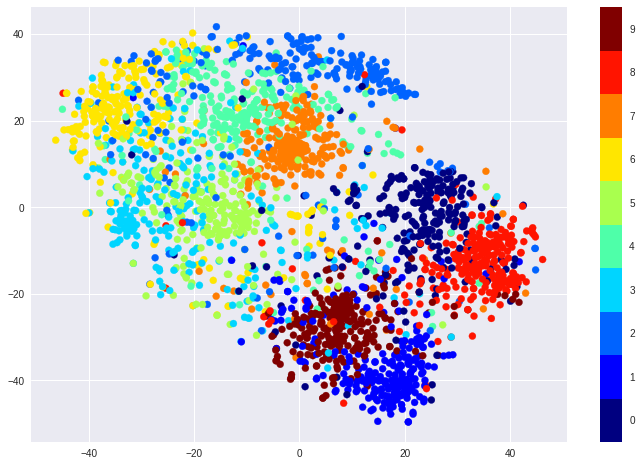

In [52]:
plot_tsne_embeddings(x_train, y_train, n=2500)

Now I'm going to use great visualization python module called Bokeh. Hover tool is making the graph interactive and it enables to check which image every observation corresponds to. The results are quite the same as above because I modelled embeddings similarly, only the form and number of samples  is different.

In [12]:
n = 700
df = tsne_fit(x_train[:n], y_train[:n], full_path_train[:n])
scatterplot_vis(df)

Loading BokehJS ...

Useful tool for looking inside black-boxed neural net architectures is Quiver. I want to visualize how one of the images looks like when passed through InceptionV3 model. In the picture below I pasted a few filters for first layer and then for one of the last layers. As we can see last layers in such a deep architecture are detecting more complex structures.

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from quiver_engine import server

quiver = InceptionV3()
server.launch(quiver, temp_folder='./quiver')

<img src="quiver.png">

# SVM

I am sticking to the task and classifying our extracted features with linear SVM with previously defined function and default parameters. Now I'm also forced to limit the dataset, because experimenting phase would be too time and computationally consuming.

In [7]:
x_train = pickle.load(open('features_train', 'rb'))[:20000]
x_test = pickle.load(open('features_test', 'rb'))[:20000]
predict_svm(x_train, x_test, y_train, y_test)

Accuracy: 0.791


Let's see how it performs with different kernel

In [31]:
predict_svm(x_train, x_test, y_train, y_test, kernel='rbf')

Accuracy: 0.7979


Alternative and much faster approach would be to use sklearn's SGD Classifier with hinge loss which is basically traditional SVM with SGD method for optimizing loss function. Alpha here is a regularization parameter, so it is equivalent to C parameter in traditional SVM. I am also using StandardScaler, because discriminative algorithms which are using a distance between observations to compute a loss function (such as SVM) are performing better with normalized input.

In [36]:
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 
sgd = SGDClassifier(loss='hinge', alpha=0.0001)
sgd.fit(x_train, y_train)
print('Accuracy: {}'.format(sgd.score(x_test, y_test)))

Accuracy: 0.8101


We end up with improved accuracy to 81%. Now I'll try to optimize parameters of SVM model using randomized search since I prefer its elasticity more than using strict gridsearch. We could also try a bayesian optimization alternatively.

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 

In [6]:
""""from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from bayes_opt import BayesianOptimization

y_train = [el[0] for el in y_train]

def svccv(C, gamma):
    val = cross_val_score(
        SVC(C=C, gamma=gamma, random_state=2),
        x_train[:20000], y_train[:20000], 'accuracy', cv=3).mean()
    return val


gp_params = {"alpha": 1e-5}

print('Instance creating...')
svcBO = BayesianOptimization(svccv,
    {'C': (0.001, 100), 'gamma': (0.0001, 0.1)})
print('Exploring...')
svcBO.explore({'C': [0.001, 0.01, 0.1], 'gamma': [0.001, 0.01, 0.1]})

svcBO.maximize(n_iter=10, **gp_params)
print('-' * 53)
print('Final Results')
print('SVC: %f' % svcBO.res['max']['max_val'])""""

SyntaxError: EOL while scanning string literal (<ipython-input-6-fd532ee42b12>, line 25)

Accuracy: 0.8143


# Alternative classifications

Now is the time to try something new. Let's check how other classification models are performing in our task. Unfortunately as I checked briefly ensemble models which are based on decision trees (RandomForest, XGB) are not doing well with this kind of data. Below you can see a quick try with SGD Logistic Regression.

In [43]:
sgd = SGDClassifier(loss='log', alpha=10e-5)
sgd.fit(x_train, y_train)
print('Accuracy: {}'.format(sgd.score(x_test, y_test)))

Accuracy: 0.8104


Simple LogReg is performing similarly to SVM for this data. Finally the last step is creating shallow neural net with one hidden layer and dropout to hopefully boost the score

In [23]:
from keras.utils import np_utils
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
model = Sequential()
model.add(Dense(128, activation = 'relu', input_shape=(2048,)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 263,562
Trainable params: 263,562
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
early_stopping = EarlyStopping(patience=3, monitor = 'val_loss')
model.fit(x_train, y_train, epochs=20, validation_split=0.2, callbacks = [early_stopping])

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 30s - loss: 0.9058 - acc: 0.6986 - val_loss: 0.6043 - val_acc: 0.7906
Epoch 2/20
40000/40000 [==============================] - 29s - loss: 0.7246 - acc: 0.7590 - val_loss: 0.5776 - val_acc: 0.8021
Epoch 3/20
40000/40000 [==============================] - 29s - loss: 0.6846 - acc: 0.7713 - val_loss: 0.5693 - val_acc: 0.8051
Epoch 4/20
40000/40000 [==============================] - 29s - loss: 0.6554 - acc: 0.7797 - val_loss: 0.5425 - val_acc: 0.8121
Epoch 5/20
40000/40000 [==============================] - 29s - loss: 0.6421 - acc: 0.7840 - val_loss: 0.5395 - val_acc: 0.8150
Epoch 6/20
40000/40000 [==============================] - 30s - loss: 0.6162 - acc: 0.7915 - val_loss: 0.5503 - val_acc: 0.8083
Epoch 7/20
40000/40000 [==============================] - 27s - loss: 0.6040 - acc: 0.7967 - val_loss: 0.5538 - val_acc: 0.8102
Epoch 8/20
40000/40000 [==============================

In [16]:
print('Accuracy: {}'.format(model.evaluate(x_test, y_test)[1]))

 9856/10000 [============================>.] - ETA: 0s

'Accuracy: 0.8148'

As we can see trying more complicated model do not always result in score improvement. We've got quite similar accuracy with using neural net.

# Final thoughts

- Project was really useful for testing myself in transfer learning approach
- Since I was using only my not so powerful CPU, I felt very limited during some processes because of my hardware. Definitely better results could be achieved using GPU. That would enable feeding the models with more data or possibility for spending more time with parameters tuning, which could improve final results.
- There is a room for experiments in selecting other layer from Inception net or trying different well-known architecture
- I could consider using data augmentation, which sometimes helps in reducing overfitting and improving accuracy, but in this particular situation creating additional data where I could not use my whole dataset is not the best idea.
- TSNE embeddings can provide useful insights for multidimensional classification problems
- Using features extracted from pretrained neural nets are definitely more recommended than Gist features for this kind of problem.
- SVM and Logit classification are performing quite similar for our dataset, where rather shallow neural net slightly improved performance.